In [1]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


Four-point sensitivities
------------------------

In this example, we illustrate how to visualize the sensitivities of four-point
arrays. You can easily loop over the plotting command to create something like:
https://www.youtube.com/watch?v=lt1qV-2d5Ps


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

We start by creating a ERT data container with three four-point arrays.



In [3]:
scheme = pg.DataContainerERT()

nelecs = 10
pos = np.zeros((nelecs, 2))
pos[:, 0] = np.linspace(5, 25, nelecs)
scheme.setSensorPositions(pos)

measurements = np.array((
    [0, 3, 6, 9],  # Dipole-Dipole
    [0, 9, 3, 6],  # Wenner
    [0, 9, 4, 5]   # Schlumberger
))

for i, elec in enumerate("abmn"):
    scheme[elec] = measurements[:,i]

scheme["k"] = ert.createGeometricFactors(scheme)

04/03/21 - 10:34:04 - pyGIMLi - INFO - Cache C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.2s x 2): C:\Users\Emerson\AppData\Roaming\pygimli\Cache\8178051129509944315


In [10]:
pos

array([[ 5.        ,  0.        ],
       [ 7.22222222,  0.        ],
       [ 9.44444444,  0.        ],
       [11.66666667,  0.        ],
       [13.88888889,  0.        ],
       [16.11111111,  0.        ],
       [18.33333333,  0.        ],
       [20.55555556,  0.        ],
       [22.77777778,  0.        ],
       [25.        ,  0.        ]])

Now we set up a 2D mesh.



In [4]:
world = mt.createWorld(start=[0, 0], end=[30, -10], worldMarker=True)
for pos in scheme.sensorPositions():
    world.createNode(pos)

mesh = mt.createMesh(world, area=.05, quality=33, marker=1)

As a last step we invoke the ERT manager and calculate the Jacobian for a
homogeneous half-space.



In [5]:
fop = ert.ERTModelling()
fop.setData(scheme)
fop.setMesh(mesh)

model = np.ones(mesh.cellCount())
fop.createJacobian(model)

04/03/21 - 09:32:42 - pyGIMLi - INFO - Found 1 regions.
04/03/21 - 09:32:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/03/21 - 09:32:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Final visualization



C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


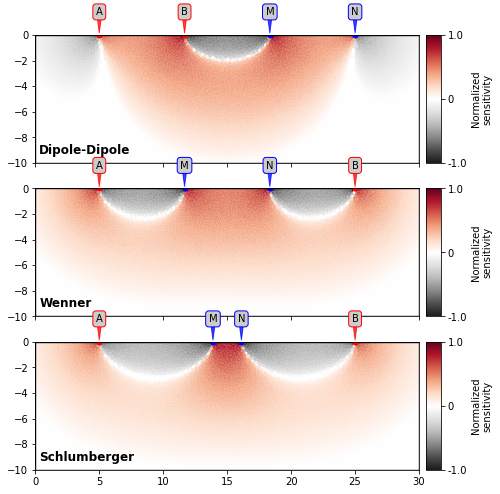

In [6]:
def getABMN(scheme, idx):
    """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
    `scheme`."""
    coords = {}
    for elec in "abmn":
        elec_id = int(scheme(elec)[idx])
        elec_pos = scheme.sensorPosition(elec_id)
        coords[elec] = elec_pos.x(), elec_pos.y()
    return coords


def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "red"
        else:
            color = "blue"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="center", fontsize=10, bbox=dict(
            boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), xytext=(0, 20),
                    textcoords='offset points', arrowprops=dict(
                        arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                        patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

labels = ["Dipole-Dipole", "Wenner", "Schlumberger"]
fig, ax = plt.subplots(scheme.size(), 1, sharex=True, figsize=(8,8))
for i, sens in enumerate(fop.jacobian()):
    # Label in lower-left corner
    ax[i].text(.01, .15, labels[i], horizontalalignment='left',
               verticalalignment='top', transform=ax[i].transAxes, fontsize=12,
               fontweight="bold")

    # Electrode annotations
    plotABMN(ax[i], scheme, i)

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 8e-4)
    normsens /= np.max(normsens)
    pg.show(mesh, normsens, cMap="RdGy_r", ax=ax[i], orientation="vertical",
            label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)